In [219]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import pickle

warnings.filterwarnings("ignore")

%matplotlib inline

In [220]:
data = pd.read_csv('filtered_movieData(9800).csv',encoding = "ISO-8859-1")

In [221]:
vectorizer = {'tfidf':TfidfVectorizer()}
##term frequency - inverse document frequency 
classifier = {'ClassifierCV':KNeighborsClassifier(weights = 'distance'), #CalibratedClassifierCV()
              'logistic_regression': LogisticRegression(multi_class="multinomial")
             }

genres = data.Genres.value_counts().reset_index()['index']

In [222]:
max_num = len(data.Overview)
for i in range(max_num):
        if type(data.Overview[i]) == float:
            data.Overview[i] = "none"

In [223]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iter = n_vec * n_clf

In [226]:
for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['Genres']]
    k = 1
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
#           print(genre.upper() + ' [' + str(k) + '/' +str(n_iter) + ']: ' + vect_name + ' - ' + clf_name )
            kf = KFold(n_splits=5, random_state=None, shuffle=False)
            pipe = Pipeline([('vect', vect), ('clf', clf)])
            
            acc = []
            prec = []
            rec = []
            f1 = []
            for train_index, test_index in kf.split(data):        
                x_train, y_train = data.Overview.iloc[train_index], data.genre_y.iloc[train_index]
                x_test, y_test = data.Overview.iloc[test_index], data.genre_y.iloc[test_index]
                pipe.fit(x_train, y_train)
                y_pred = pipe.predict(x_test)
                acc.append(np.mean(y_pred==y_test))
                prec.append(precision_score(y_test, y_pred))
                rec.append(recall_score(y_test, y_pred))
                f1.append(f1_score(y_test, y_pred))
            k+=1


In [227]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iterations = n_vec*n_clf

temp = data.copy()

test_result = {}

for genre in genres[:9]:
    temp['genre_y'] = [1 if y == genre else 0 for y in temp['Genres']]
    k = 1
    final_score = {}
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
            kf = KFold(n_splits=5, random_state=None, shuffle=False)
            
            acc_normal = []
            prec_normal = []
            rec_normal = []
            f1_normal = []
            auc_normal = []
            
            acc_over = []
            prec_over = []
            rec_over = []
            f1_over = []
            auc_over = []
            
            acc_under = []
            prec_under = []
            rec_under = []
            f1_under = []
            auc_under = []
            
            i = 1
            x, y = temp.Overview, temp.genre_y
            for train_index, test_index in kf.split(data):
                x_train, y_train = x.iloc[train_index], y.iloc[train_index]
                x_test, y_test = x.iloc[test_index], y.iloc[test_index]
                
                train_vect = vect.fit_transform(x_train)
             
                clf.fit(train_vect, y_train)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_normal.append(np.mean(y_pred==y_test))
                prec_normal.append(precision_score(y_test, y_pred))
                rec_normal.append(recall_score(y_test, y_pred))
                f1_normal.append(f1_score(y_test, y_pred))
                auc_normal.append(roc_auc_score(y_test, y_pred))

                
                train_vect_over, y_train_over = SMOTE().fit_resample(train_vect, y_train) 
                clf.fit(train_vect_over, y_train_over)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_over.append(np.mean(y_pred==y_test))
                prec_over.append(precision_score(y_test, y_pred))
                rec_over.append(recall_score(y_test, y_pred))
                f1_over.append(f1_score(y_test, y_pred))
                auc_over.append(roc_auc_score(y_test, y_pred))
                #print('Overfitting: iteration ' + str(i) + ': ')
                
                train_vect_under, y_train_under = EditedNearestNeighbours().fit_resample(train_vect, y_train) 
                clf.fit(train_vect_under, y_train_under)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_under.append(np.mean(y_pred==y_test))
                prec_under.append(precision_score(y_test, y_pred))
                rec_under.append(recall_score(y_test, y_pred))
                f1_under.append(f1_score(y_test, y_pred))
                auc_under.append(roc_auc_score(y_test, y_pred))
                i+=1
            k+=1
            #final_score[(vect_name, clf_name, 'over')] = np.mean(auc_over)
            final_score[(vect_name, clf_name, 'normal')] = np.mean(auc_normal)
            #final_score[(vect_name, clf_name, 'under')] = np.mean(auc_under)
            #print(final_score.keys())
    test_result[genre] = max(final_score, key=final_score.get)
    print(genre , test_result[genre])

Action ('tfidf', 'ClassifierCV', 'normal')
Drama ('tfidf', 'ClassifierCV', 'normal')
Comedy ('tfidf', 'ClassifierCV', 'normal')
Horror ('tfidf', 'ClassifierCV', 'normal')
Animation ('tfidf', 'ClassifierCV', 'normal')
Adventure ('tfidf', 'ClassifierCV', 'normal')
Thriller ('tfidf', 'ClassifierCV', 'normal')
Crime ('tfidf', 'ClassifierCV', 'normal')
Science Fiction ('tfidf', 'ClassifierCV', 'normal')


In [228]:
pipe_dict = {}
for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['Genres']]
    vect_name = test_result[genre][0]
    clf_name = test_result[genre][1]
    sampling_name = test_result[genre][2]

    vect = clone(vectorizer[vect_name])
    clf = clone(classifier[clf_name])
    
    x_vect = vect.fit_transform(data.Overview)
    
    if sampling_name == 'normal':
        clf.fit(x_vect, data.genre_y)
    elif sampling_name == 'over':
        x_vect, y = SMOTE().fit_resample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    elif sampling_name == 'under':
        x_vect, y = EditedNearestNeighbours().fit_resample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    pipe_dict[genre] = Pipeline([('vect', vect), ('clf', clf)])

In [257]:
def predict_genre(s, pipe_dict):
    #s_new = clean_sentence(s)
    genre_analyzed = []
    proba = []
    for genre, pipe in pipe_dict.items():
        res = pipe.predict_proba([s])
        #print( genre,pipe.predict_proba([s]))
        genre_analyzed.append(genre)
        proba.append(res[0][1])
        genre_idx = np.argmax(proba)
    
    print(s," : ", genre_analyzed[genre_idx], round( max(proba) * 100, 2), "%")
    data = pd.DataFrame({'genre': genre_analyzed, 'proba': proba})
    data = data.sort_values(by='proba', ascending=True)
    ax = data.plot(x='genre', y='proba', kind='barh')

death  :  Science Fiction 39.67 %


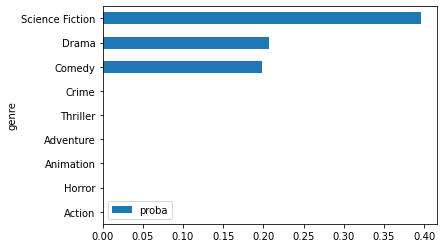

In [266]:
predict_genre("", pipe_dict)

In [265]:
with open("trained_data(normal_fit).txt","wb") as fw:
    pickle.dump(pipe_dict,fw)